In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets sentencepiece evaluate jiwer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 78.2 MB/s eta 0:00:00:00:01


In [2]:
%%bash
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
cp -r ICDAR-2019-SROIE/data ./
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


In [3]:
import os
import json
from pathlib import Path
import shutil
import transformers
 
transformers.logging.disable_default_handler()
 
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
metadata_list = []
 
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    data = json.load(json_file)
    text = json.dumps(data)
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
 
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')
 
shutil.rmtree(metadata_path)

In [4]:
from datasets import load_dataset

base_path = Path("data")
image_path = base_path.joinpath("img")
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
task_start_token = "<s>"
eos_token = "</s>"
new_special_tokens = []

def json2token(obj, update_special_tokens_for_json_key=True, sort_json_key=True):
    if isinstance(obj, dict):
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        
        output = ""
        keys = sorted(obj.keys(), reverse=True) if sort_json_key else obj.keys()
        for k in keys:
            if update_special_tokens_for_json_key:
                new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
            output += (
                fr"<s_{k}>"
                + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                + fr"</s_{k}>"
            )
        return output
    elif isinstance(obj, list):
        return r"<sep/>".join([json2token(item) for item in obj])
    else:
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"
        return obj

In [6]:
def collect_special_tokens(sample):
    text = json.loads(sample["text"])
    json2token(text)
    return sample

_ = dataset.map(collect_special_tokens)

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

In [7]:
from transformers import DonutProcessor

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.image_processor.size = [720, 960]
processor.image_processor.do_align_long_axis = False

new_special_tokens = list(set(new_special_tokens))
new_special_tokens.sort()

processor.tokenizer.add_special_tokens({
    "additional_special_tokens": new_special_tokens + [task_start_token, eos_token]
})

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

8

In [8]:
from transformers import VisionEncoderDecoderModel, logging

logging.set_verbosity_error()
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
logging.set_verbosity_warning()

model.decoder.resize_token_embeddings(len(processor.tokenizer))
model.config.encoder.image_size = processor.image_processor.size[::-1]
model.config.decoder.max_length = 512
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([task_start_token])[0]

model.config.vocab_size = len(processor.tokenizer)
model.generation_config.max_length = model.config.decoder.max_length
model.generation_config.eos_token_id = processor.tokenizer.eos_token_id
model.generation_config.pad_token_id = processor.tokenizer.pad_token_id

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [9]:
def preprocess_documents_for_donut(sample):
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text, update_special_tokens_for_json_key=False) + eos_token
    return {"image": sample["image"].convert("RGB"), "text": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

In [10]:
def transform_and_tokenize(sample):
    try:
        pixel_values = processor(
            sample["image"], 
            return_tensors="pt",
        ).pixel_values.squeeze()
    except Exception as e:
        print(f"Error processing image: {e}")
        return {}

    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixel_values, "labels": labels}

processed_dataset = proc_dataset.map(
    transform_and_tokenize,
    remove_columns=["image", "text"]
).train_test_split(test_size=0.1)

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Legacy behavior is being used. The current behavior will be deprecated in version 5.0.0. In the new behavior, if both images and text are provided, the default value of `add_special_tokens` will be changed to `False` when calling the tokenizer if `add_special_tokens` is unset. To test the new behavior, set `legacy=False`as a processor call argument.


In [11]:
print(f"Decoder max length: {model.config.decoder.max_length}")
print(f"Longest label length: {len(max(processed_dataset['train']['labels'], key=len))}")
print(f"Number of special tokens: {len(processor.tokenizer.additional_special_tokens)}")
print(f"Start token ID: {model.config.decoder_start_token_id} (should be {processor.tokenizer.convert_tokens_to_ids('<s>')})")
print(f"Pad token ID: {model.config.pad_token_id} (should be {processor.tokenizer.pad_token_id})")
print(f"Encoder image size: {model.config.encoder.image_size}")
print(f"Processor feature extractor size: {processor.image_processor.size}")
print(f"Tokenizer vocab size: {len(processor.tokenizer)}")
print(f"Decoder embedding size: {model.decoder.get_input_embeddings().num_embeddings}")

Decoder max length: 512
Longest label length: 512
Number of special tokens: 10
Start token ID: 0 (should be 0)
Pad token ID: 1 (should be 1)
Encoder image size: [960, 720]
Processor feature extractor size: [720, 960]
Tokenizer vocab size: 57533
Decoder embedding size: 57533


In [12]:
import numpy as np
import evaluate

wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
    
    pred_str = processor.tokenizer.batch_decode(preds, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    pred_str = [pred.split(eos_token)[0] for pred in pred_str]
    label_str = [label.split(eos_token)[0] for label in label_str]
    
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"wer": wer, "cer": cer}

In [13]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback

class CustomSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        inputs.pop("num_items_in_batch", None)
        return super().compute_loss(model, inputs, return_outputs=return_outputs)

batch_size = 2
gradien_acc = 32

training_args = Seq2SeqTrainingArguments(
    output_dir="donut-base-sroie",
    num_train_epochs=80,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradien_acc,
    
    optim="adamw_torch_fused",
    learning_rate=1e-5,
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    warmup_steps=int(0.1 * (563 / batch_size * gradien_acc)),
    
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    
    save_total_limit=1,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    overwrite_output_dir=True,
    report_to="none",
    
    predict_with_generate=True,
    max_grad_norm=1.0,
    metric_for_best_model="eval_wer",
    
    greater_is_better=False,
    load_best_model_at_end=True,
    
    dataloader_num_workers=4,
    dataloader_prefetch_factor=4,
    dataloader_pin_memory=True,
    fp16=True,
    bf16=False,
)

trainer = CustomSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["test"],
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [14]:
trainer.train(resume_from_checkpoint=False)

`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Wer,Cer
0,125.301000,7.173359,8.884440,4.667817
1,118.758700,6.541475,6.163785,3.494610
2,108.348900,5.813296,3.060055,2.106511
3,98.194700,5.131253,1.182894,1.148340
4,87.251000,4.534514,1.176524,1.064539
5,77.956200,4.049232,1.188353,1.063389
6,69.898500,3.627985,1.040946,1.071008
7,63.347100,3.245710,1.000000,1.000000
8,57.257100,2.937681,1.000000,1.060658
9,51.952700,2.733245,1.000000,0.999569


There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].


TrainOutput(global_step=170, training_loss=85.8266019933364, metrics={'train_runtime': 5597.675, 'train_samples_per_second': 1.006, 'train_steps_per_second': 0.03, 'total_flos': 9.663329593523405e+18, 'train_loss': 85.8266019933364, 'epoch': 9.964539007092199})

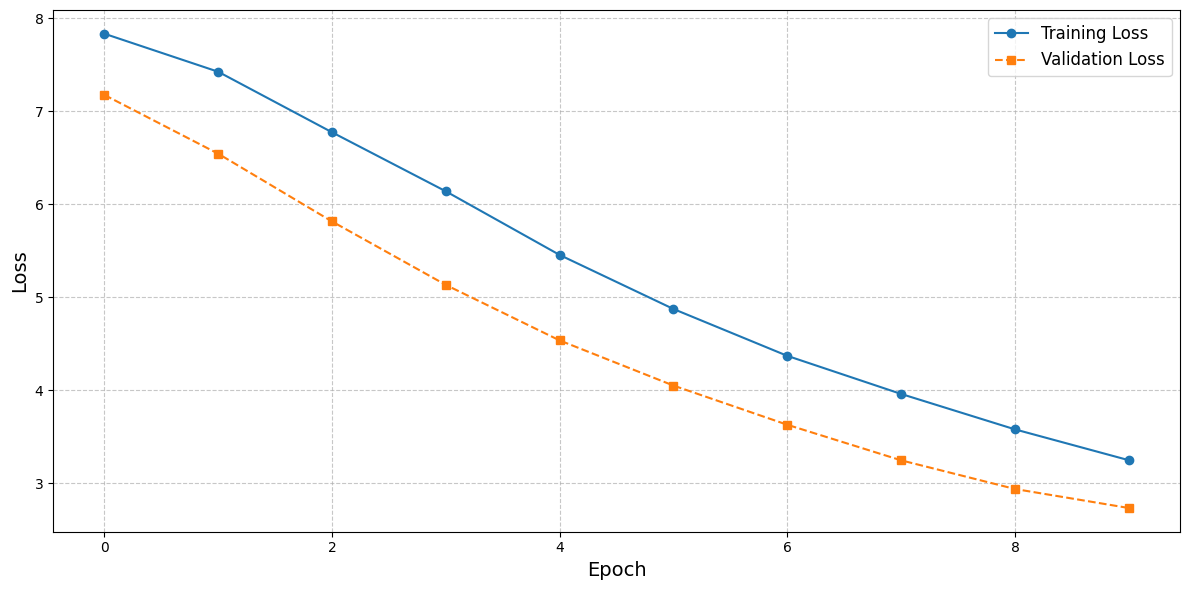

In [15]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = [log["loss"] / gradien_acc for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
epochs = list(range(len(eval_loss)))

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-', color='#1f77b4')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='s', linestyle='--', color='#ff7f0e')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig('loss_plot.png', dpi=300)
plt.show()

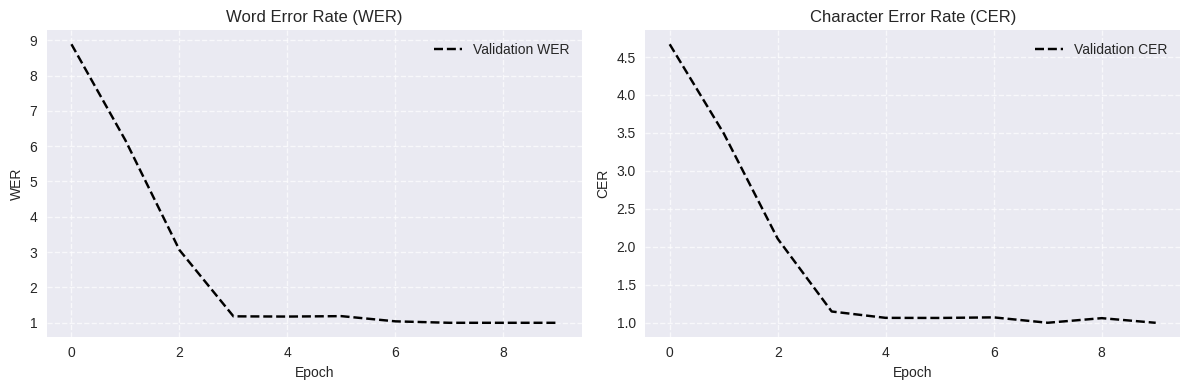

In [42]:
eval_wer = [log["eval_wer"] for log in logs if "eval_wer" in log]
eval_cer = [log["eval_cer"] for log in logs if "eval_cer" in log]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, eval_wer, label='Validation WER', linestyle='--', color='black')
plt.title('Word Error Rate (WER)', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('WER', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, eval_cer, label='Validation CER', linestyle='--', color='black')
plt.title('Character Error Rate (CER)', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('CER', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('metrics_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
model.save_pretrained("./trained_donut")
processor.save_pretrained("./trained_donut")
print("--SAVED--")

--SAVED--


In [31]:
import torch

logging.set_verbosity_error()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VisionEncoderDecoderModel.from_pretrained("./trained_donut").to(device)
processor = DonutProcessor.from_pretrained("./trained_donut")
logging.set_verbosity_warning()

In [36]:
def run_prediction(sample, model=model, processor=processor):
    pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=4,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    prediction = processor.batch_decode(outputs.sequences, skip_special_tokens=True)[0]
    prediction = processor.token2json(prediction)

    labels = np.array(sample["labels"])
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
    label_str = processor.tokenizer.decode(labels, skip_special_tokens=True)
    target = processor.token2json(label_str)

    return prediction, target

In [37]:
import random

test_sample = processed_dataset["test"][random.randint(1, 50)]
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

Reference:
 {'text_sequence': '87.45 30-05-2018 ONE ONE THREE SEAFOOD RESTAURANT SDN BHD NO., TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.'}
Prediction:
 {'text_sequence': 'ONE ONE THREE SEAFOOD RESTAURANT SDN BHD ONE ONE THREE SEAFOOD RESTAURANT SDN BHD N.O.I, TAMAN SRT DENKKI, JALAN AIR HITAM 43800 DENKKI, SELANGOR. (GST REg. Reg. No. : 0006070224334) TAX. Invo 1 ce Table 331 61114:0001-539327 Order#: 139430 ONE ONE THREE SEAFOOD RESTAURANT SDN BHD NO.11, TAMAN SDI, JAMAN SDN BHD藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥的藥,'}
